## final project submission

Please fill out:
* Student name: Claire Sarraille
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from statsmodels.stats.outliers_influence import variance_inflation_factor




%matplotlib inline

/Users/clairesarraille/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## crisp-dm:

- Business Understanding
    - Who will be  using the model
    - How will the model be used
    - How will using the model help our business
    - clarify requirements
    - What problems are in and out of scope

- Understand Data
    - What is target
    - What are predictors
    - Distribution of Data
    - How many observations - and is this a small, medium or large collection?
    - What is the quality? - What errors could be in the data, or inaccuracy?

- Data Preparation - Prepping to model
    - Missing values
    - Type conversions
    - Remove multicollinearity (correlated predictors)
    - Normalize numeric data
    - Convert categorical data to numeric via one-hot encoding

- Modeling:
    - Tune models to get the highest performance possible on our task
    - Considerations:
        - What kind of task? Classification task? Regression task?
        - Which models will we use
        - Will be use regularization?
        - How will we validate our model?
        - Loss functions?
        - What is the performance threshold for success?

- Evaluation:
    - Does the model solve business problem outlined in step 1?
    - At this point, we may want to start over at the business understanding step, now that we have a deeper understanding
    - Things we may learn at this stage:
        - Need different data
        - Need more data
        - Should be going in a different direction
        - Should use classificaion rather than regression, or vice versa
        - Use different approach

- Deployment:
    - Move the model into production
    - Set up ETL - how much of preprocessing and cleaning can be automated?


# BUSINESS UNDERSTANDING
- Who will be  using the model
    - The real estate agency I work for
- How will the model be used
    - Help home owners buy and/or sell homes
- How will using the model help our business
    - We can give good advice to homeowners about how home renovations might increase the estimate value of their homes, and by how much
- clarify requirements
    - Find the features that are highest correlated with a higher sell price. Find how many dollars each unit of each feature adds to price
    - Use these correlations to recommend home renovations, ranked by the most to least positive impact on price.
- What problems are in and out of scope
    - How do home renovations impact the sell price of a home.
    - We are not looking at other factors, such as location (waterfront), which the owner can't renovate the house to have.

In [3]:
# Read in Data:
df = pd.read_csv('data/kc_house_data.csv')

## Remove features
- id ( we don't want our model thinking that id has explanatory power since we know it has nothing to do with price)
- date (same for date - no explanatory value)
- view (this is repeating info from waterfront)
- sqft_above (repeating sqft_living)
- sqft_basemenat (repeating sqft_living)
- yr_renovated (repeating yr_built)
- Not helpful to have geographic features becuase renovation can't inclue re-locating house (ostensibly)
    - zipcode
    - lat
    - long
- sqft_living15 (repeating sqft_living)
- sqft_lot15 (repeating sqft_lot)

In [4]:
# Why reduce features?
# I narrowed my list of features so that I could avoid overfitting the training dataset
# Reducing redundancy in features increases the accuracy of the model
# I also removed 'id' because this field likely has little to no predictive value

df = df.drop(['id','date','view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1)

In [5]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1955
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987


# UNDERSTAND DATA
- What is target
    - price
- What are predictors
    - sqft_living, bathrooms, bedrooms, floors, sqft_lot, condition
- Distribution of Data
- How many observations - and is this a small, medium or large collection?
    - 21,597 entries
    - According to Frank Harrell in his book Regression Modeling Strategies, you need at least 10-20 observations per predictor
    - We have many, many more observations than 20 * (6 - num covariates) = 120
    - Our dataset would be considered large
- What is the quality? - What errors could be in the data, or inaccuracy?

## New Columns 

In [6]:
# Create lot size in acres:
df['acres_lot'] = df['sqft_lot'] / 43560 

In [7]:
# Create price column in millions:
df['price_millions'] = df['price'] / 1000000

In [8]:
df[['price_millions','price', 'acres_lot']]

,price_millions,price,acres_lot
0,0.221900,221900.0,0.129706
1,0.538000,538000.0,0.166253
2,0.180000,180000.0,0.229568
3,0.604000,604000.0,0.114784
4,0.510000,510000.0,0.185491
...,...,...,...
21592,0.360000,360000.0,0.025964
21593,0.400000,400000.0,0.133448
21594,0.402101,402101.0,0.030992
21595,0.400000,400000.0,0.054821


In [9]:
print(f"The max price is {df['price_millions'].max()} million, min price is {df['price'].min()}")

The max price is 7.7 million, min price is 78000.0


## Price Frequency Histogram

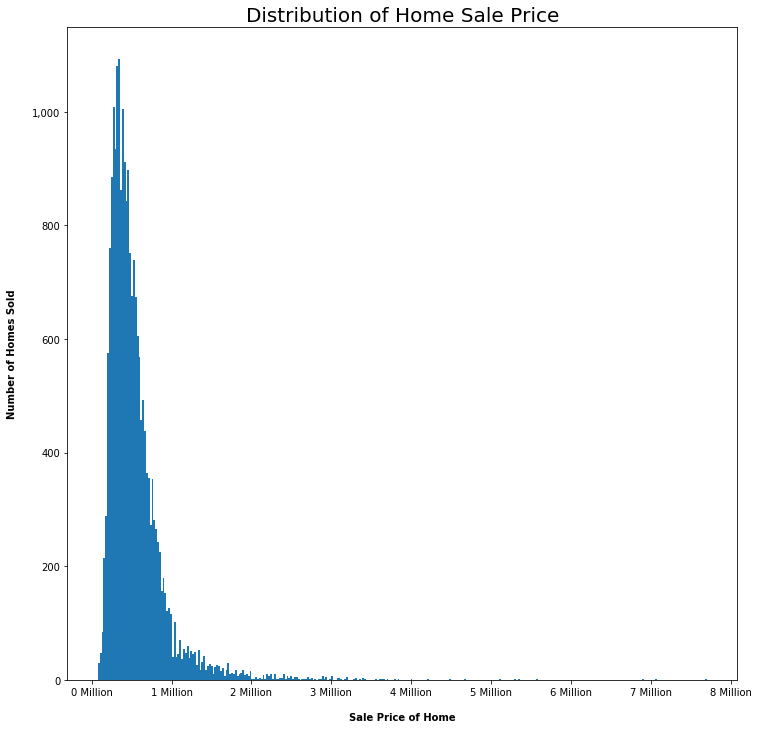

In [10]:
ax = df.hist(column='price_millions',
             bins='auto',
             grid=False,
             figsize=(12, 12))

ax = ax[0]
for x in ax:

    x.set_title("Distribution of Home Sale Price", size=20)

    # Set x-axis label
    x.set_xlabel("Sale Price of Home", labelpad=15, weight='bold', size=10)
    x.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}' + ' Million'))

    # Set y-axis label
    x.set_ylabel("Number of Homes Sold", labelpad=15, weight='bold', size=10)
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


## Quality - Possible Errors

- There could be outliers - such as hundreds of bathrooms - which doesn't make sense with square footage
- Year could be in the future
- price could be a negative number
- datatype could be wrong - such as string for number of bedrooms

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           21597 non-null  float64
 1   bedrooms        21597 non-null  int64  
 2   bathrooms       21597 non-null  float64
 3   sqft_living     21597 non-null  int64  
 4   sqft_lot        21597 non-null  int64  
 5   floors          21597 non-null  float64
 6   waterfront      19221 non-null  float64
 7   condition       21597 non-null  int64  
 8   grade           21597 non-null  int64  
 9   yr_built        21597 non-null  int64  
 10  acres_lot       21597 non-null  float64
 11  price_millions  21597 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 2.0 MB


In [12]:
# The only field that I retained containing NaN values is waterfront:
df.isnull().sum()

price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront        2376
condition            0
grade                0
yr_built             0
acres_lot            0
price_millions       0
dtype: int64

## Outliers using IQR
- I'm not sure if I'll need to drop outliers
- Nonetheless it was interesting to see where the extreme outliers are located.

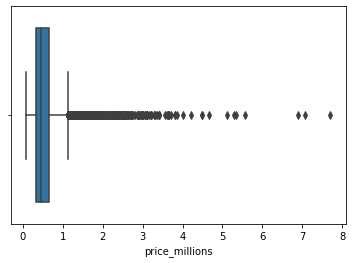

In [13]:
sns.boxplot(x=df['price_millions'])


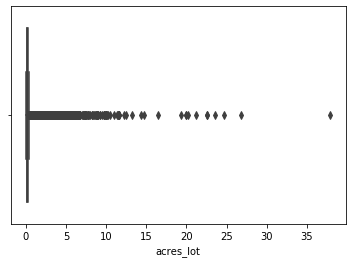

In [14]:
sns.boxplot(x=df['acres_lot'])


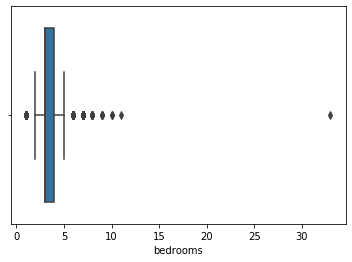

In [15]:
sns.boxplot(x=df['bedrooms'])


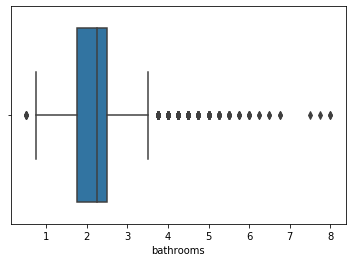

In [16]:
sns.boxplot(x=df['bathrooms'])


## Outliers using Sorting

In [17]:
df.sort_values('price_millions', ascending = False).head(15)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,acres_lot,price_millions
7245,7700000.0,6,8.00,12050,27600,2.5,0.0,4,13,1910,0.633609,7.70
3910,7060000.0,5,4.50,10040,37325,2.0,1.0,3,11,1940,0.856864,7.06
9245,6890000.0,6,7.75,9890,31374,2.0,0.0,3,13,2001,0.720248,6.89
4407,5570000.0,5,5.75,9200,35069,2.0,0.0,3,13,2001,0.805073,5.57
1446,5350000.0,5,5.00,8000,23985,2.0,0.0,3,12,2009,0.550620,5.35
1313,5300000.0,6,6.00,7390,24829,2.0,1.0,4,12,1991,0.569995,5.30
1162,5110000.0,5,5.25,8010,45517,2.0,1.0,3,12,1999,1.044927,5.11
8085,4670000.0,5,6.75,9640,13068,1.0,1.0,3,12,1983,0.300000,4.67
2624,4500000.0,5,5.50,6640,40014,2.0,1.0,3,12,2004,0.918595,4.50
8629,4490000.0,4,3.00,6430,27517,2.0,0.0,3,12,2001,0.631703,4.49


In [18]:
df.sort_values('bedrooms', ascending = False).head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,acres_lot,price_millions
15856,640000.0,33,1.75,1620,6000,1.0,0.0,5,7,1947,0.137741,0.640000
8748,520000.0,11,3.00,3000,4960,2.0,0.0,3,7,1918,0.113866,0.520000
13301,1150000.0,10,5.25,4590,10920,1.0,0.0,3,9,2008,0.250689,1.150000
19239,660000.0,10,3.00,2920,3745,2.0,0.0,4,7,1913,0.085973,0.660000
15147,650000.0,10,2.00,3610,11914,2.0,0.0,4,7,1958,0.273508,0.650000
6073,1280000.0,9,4.50,3650,5000,2.0,0.0,3,8,1915,0.114784,1.280000
4231,700000.0,9,3.00,3680,4400,2.0,0.0,3,7,1908,0.101010,0.700000
16830,1400000.0,9,4.00,4620,5508,2.5,0.0,3,11,1915,0.126446,1.400000
8537,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,1996,0.149311,0.450000
4092,599999.0,9,4.50,3830,6988,2.5,0.0,3,7,1938,0.160422,0.599999


In [19]:
df.sort_values('bathrooms', ascending = False).head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,acres_lot,price_millions
12764,2280000.0,7,8.00,13540,307752,3.0,0.0,3,12,1999,7.065014,2.28
7245,7700000.0,6,8.00,12050,27600,2.5,0.0,4,13,1910,0.633609,7.70
9245,6890000.0,6,7.75,9890,31374,2.0,0.0,3,13,2001,0.720248,6.89
8537,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,1996,0.149311,0.45
4020,800000.0,7,6.75,7480,41664,2.0,0.0,3,11,1953,0.956474,0.80
8085,4670000.0,5,6.75,9640,13068,1.0,1.0,3,12,1983,0.300000,4.67
20562,1180000.0,6,6.50,6260,10955,2.0,NaN,3,11,2007,0.251492,1.18
21490,2240000.0,5,6.50,7270,130017,2.0,0.0,3,12,2010,2.984780,2.24
14542,2890000.0,5,6.25,8670,64033,2.0,0.0,3,13,1965,1.469995,2.89
18288,3300000.0,5,6.25,8020,21738,2.0,0.0,3,11,2001,0.499036,3.30


In [20]:
df.sort_values('sqft_living', ascending = False).head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,acres_lot,price_millions
12764,2280000.0,7,8.00,13540,307752,3.0,0.0,3,12,1999,7.065014,2.28
7245,7700000.0,6,8.00,12050,27600,2.5,0.0,4,13,1910,0.633609,7.70
3910,7060000.0,5,4.50,10040,37325,2.0,1.0,3,11,1940,0.856864,7.06
9245,6890000.0,6,7.75,9890,31374,2.0,0.0,3,13,2001,0.720248,6.89
8085,4670000.0,5,6.75,9640,13068,1.0,1.0,3,12,1983,0.300000,4.67
4407,5570000.0,5,5.75,9200,35069,2.0,0.0,3,13,2001,0.805073,5.57
14542,2890000.0,5,6.25,8670,64033,2.0,0.0,3,13,1965,1.469995,2.89
18288,3300000.0,5,6.25,8020,21738,2.0,0.0,3,11,2001,0.499036,3.30
1162,5110000.0,5,5.25,8010,45517,2.0,1.0,3,12,1999,1.044927,5.11
1446,5350000.0,5,5.00,8000,23985,2.0,0.0,3,12,2009,0.550620,5.35


In [21]:
df.sort_values('acres_lot', ascending = False).head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,acres_lot,price_millions
1717,700000.0,4,1.00,1300,1651359,1.0,0.0,4,6,1920,37.909986,0.7000
17305,190000.0,2,1.00,710,1164794,1.0,0.0,2,5,1915,26.739991,0.1900
7640,542500.0,5,3.25,3010,1074218,1.5,NaN,5,8,1931,24.660652,0.5425
7762,855000.0,4,3.50,4030,1024068,2.0,0.0,3,10,2006,23.509366,0.8550
3945,998000.0,4,3.25,3770,982998,2.0,0.0,3,10,1992,22.566529,0.9980
4437,790000.0,2,3.00,2560,982278,1.0,0.0,3,8,2004,22.550000,0.7900
6685,2000000.0,2,2.50,3900,920423,2.0,0.0,3,12,2009,21.130005,2.0000
7070,1650000.0,4,3.25,3920,881654,3.0,NaN,3,11,2002,20.239991,1.6500
9705,937500.0,4,4.00,5545,871200,2.0,0.0,3,11,2003,20.000000,0.9375
20436,1600000.0,4,5.50,6530,871200,2.0,0.0,3,11,2008,20.000000,1.6000


## Descriptive Statistics Table

In [22]:
format_dict = {'bedrooms' : '{:.2f}', 'bathrooms' : '{:.2f}', 'floors' : '{:.2f}', 'sqft_living' : '{:20,.2f}', 'sqft_lot' : '{:20,.2f}', 'acres_lot' : '{:.2f}',  'price' : '${:20,.0f}', 'yr_built' : '{:.0f}'}
df[['price', 'yr_built', 'bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot', 'acres_lot']].describe().style.format(format_dict)

,price,yr_built,bedrooms,bathrooms,floors,sqft_living,sqft_lot,acres_lot
count,"$ 21,597",21597,21597.00,21597.00,21597.00,"21,597.00","21,597.00",21597.00
mean,"$ 540,297",1971,3.37,2.12,1.49,"2,080.32","15,099.41",0.35
std,"$ 367,368",29,0.93,0.77,0.54,918.11,"41,412.64",0.95
min,"$ 78,000",1900,1.00,0.50,1.00,370.00,520.00,0.01
25%,"$ 322,000",1951,3.00,1.75,1.00,"1,430.00","5,040.00",0.12
50%,"$ 450,000",1975,3.00,2.25,1.50,"1,910.00","7,618.00",0.17
75%,"$ 645,000",1997,4.00,2.50,2.00,"2,550.00","10,685.00",0.25
max,"$ 7,700,000",2015,33.00,8.00,3.50,"13,540.00","1,651,359.00",37.91


## Interpret Descriptive Statistics
- There are no negative values for any of the columns
- The year range makes sense: homes were built between 1900 and 2015
- sqft_living average is around 2,000, which is close to the US average
- The average lot size is 15,099 square feet, or .35 acres
- The lot size mean is skewed by our outlier home, which stands on a 37.91 acre lot.
- The median sqft_lot size is 7,618 or .17 acres, which is much closer to the national average of 0.188 of an acre.

# DATA PREPARATION
- Prepping to model
- Missing values
- Convert categorical data to numeric via one-hot encoding (we didn't need to do this)
- Type conversions (this was done in the previous section - price to millions and sqft to acres)
- Remove multicollinearity (correlated predictors)
- Normalize numeric data


## Waterfront Missing Values 
I filled in NaN values for 'waterfront' with 0. Now, 'waterfront' has a 1 value if there is a view, and 0 value if there is not.
I also cast this column as an integer type since there are no other options besides the integers 1 and 0.

In [23]:
df['waterfront'] = df['waterfront'].fillna(0)

In [24]:
df['waterfront'] = df["waterfront"].astype(int)

In [25]:
# Note: waterfront is our only categorical value.
# We don't need to use dummy coding or any other coding system because it's already dichotomous (1 or 0) 
df['waterfront'].unique()

array([0, 1])

## Pickle Save

In [26]:
# Write Data to Pickle:
with open('df_data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)

In [50]:
# Read Data from Pickle:
with open('df_data.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    df = pickle.load(f)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,acres_lot,price_millions
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1955,0.129706,0.2219
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,1951,0.166253,0.5380
2,180000.0,2,1.00,770,10000,1.0,0,3,6,1933,0.229568,0.1800
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1965,0.114784,0.6040
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1987,0.185491,0.5100


## Scatter Matrix Distribution

In [51]:
# Select a subset of columns to create matrix:
df_scatter = df.drop(['price','condition','sqft_lot','waterfront','grade','yr_built', 'floors'], axis=1)

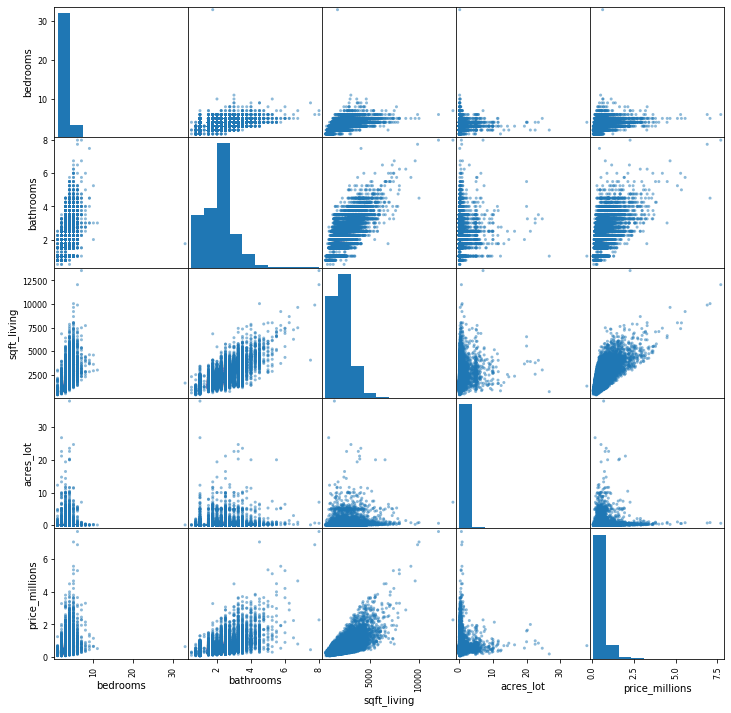

In [52]:
pd.plotting.scatter_matrix(df_scatter, figsize=(12,12))
plt.show()

## Waterfront-Price Density Histogram
Let's show another type of distribution now that we have "waterfront" column cleaned up

In [53]:
# Density histogram of house price - waterfront vs. non-waterfront:
water_df =  df.loc[df['waterfront'] == 1]
no_water_df =  df.loc[df['waterfront'] == 0]

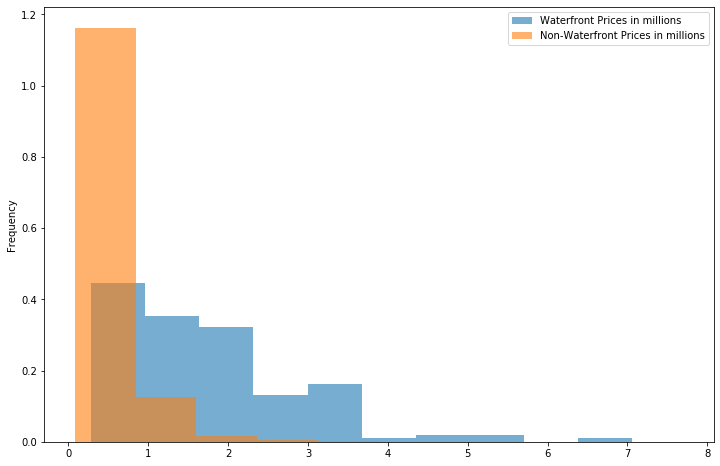

In [54]:
# Plot histograms (with densities on the y-axis) for waterfront and non-waterfront house prices:
plt.figure(figsize = (12,8))
binsize = 10
water_df.price_millions.plot.hist(bins = binsize, density = True,  alpha = 0.6, label ="Waterfront Prices in millions");
no_water_df.price_millions.plot.hist(bins = binsize, density = True, alpha = 0.6, label = 'Non-Waterfront Prices in millions');
plt.legend()
plt.show()


## Interpret Waterfront-Price Density Histogram
- Waterfront properties tend to have higher selling prices than non-waterfront properties
- Waterfront properties have a higher spread than non-watefront properties - that's why the waterfront peak is smaller than the non-waterfront peak
- Neither price distributions are normally distributed
- Waterfront and non-waterfront properties overlap in price from about .3-.7 million

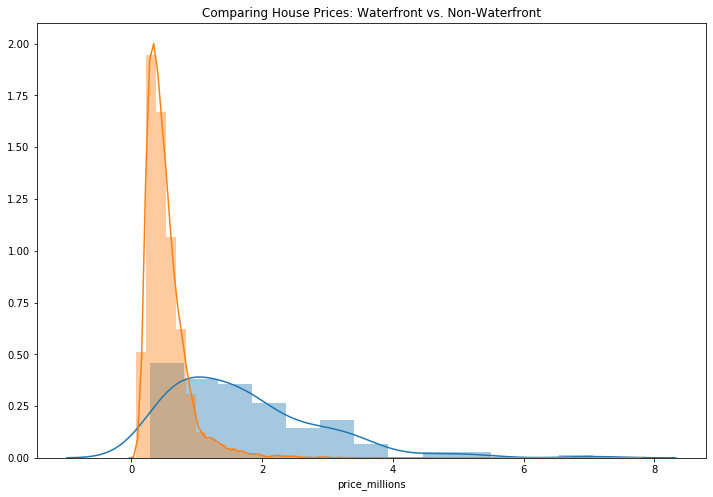

In [55]:
# Ok. Now let's draw a smooth curve, given the above data, using KDE (kernal density estimation)
# The smooth line in the visualization below is an estimate of the distributions of waterfront and non-waterfront house prices
# The parameter bandwidth rules the smoothness of the underlying distribution

# The problem with a Probability Density Function plot, is that all "point probabilities" are 0
# We must calculate the area under the curve for an interval to get the actual probability for an interval of house prices.
# Thus, it's not intuitive or easy to "read" the y-axis to get probabilities for continuous variables using a PDF like below.

plt.figure(figsize = (12,8))
sns.distplot(water_df.price_millions,kde=True)
sns.distplot(no_water_df.price_millions,kde=True)
plt.title('Comparing House Prices: Waterfront vs. Non-Waterfront')
plt.show()




For example, if we wanted to know the probability that a waterfront house price is between 2 and 4 million dollars (inclusive), we would use the following formula to take the integral of this range (AKA area under the curve)
$$\large P(2 \leq X \leq 4) = \int_{2}^{4} f_x(x) dx \geq 0 $$


## Price Density Histogram

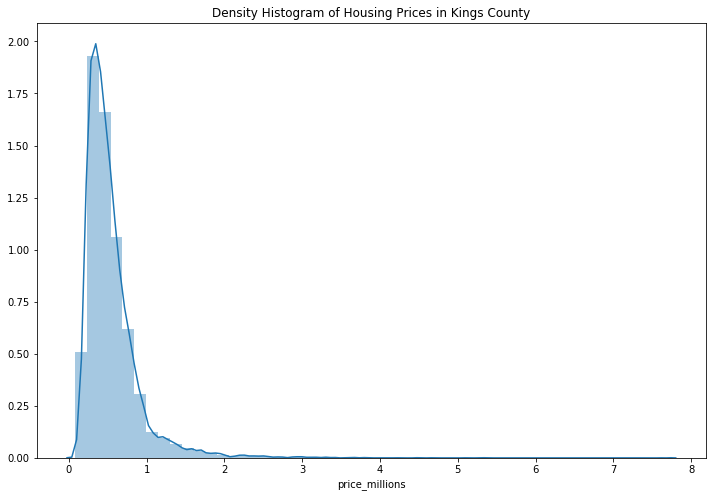

In [56]:
# From this we can see that generally, most houses are priced below one million dollars
plt.figure(figsize = (12,8))
sns.distplot(df.price_millions,kde=True)
plt.title('Density Histogram of Housing Prices in Kings County')
plt.show()

In [57]:
# Let's review what is in df:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,acres_lot,price_millions
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1955,0.129706,0.2219
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,1951,0.166253,0.5380
2,180000.0,2,1.00,770,10000,1.0,0,3,6,1933,0.229568,0.1800
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1965,0.114784,0.6040
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1987,0.185491,0.5100


In [58]:
# Create a Sensible df for modeling:
df_model = df.drop(['acres_lot', 'price'], axis=1)

In [59]:
correlations = df_model.corr()

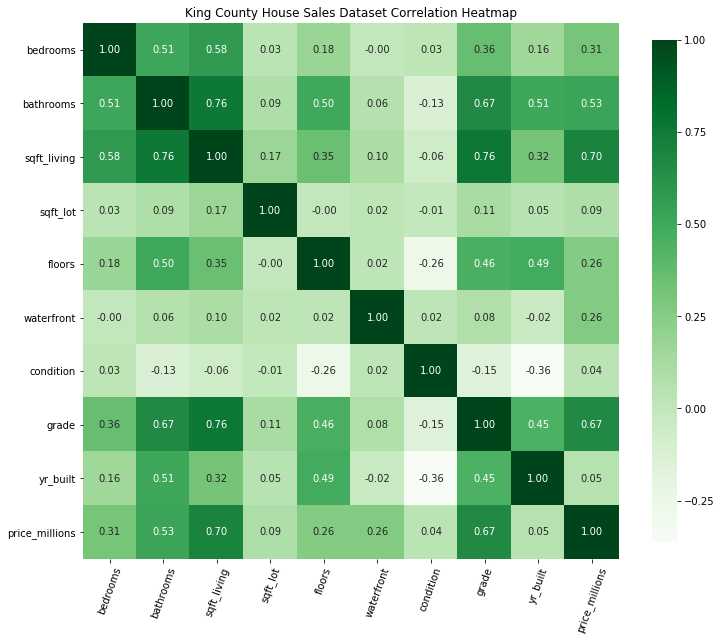

In [60]:
plt.figure(figsize=(12,12)) # Set size of figure
# Use df.corr() as your matrix for the heatmap
# I set the color scheme to green using cmap
# annot= True adds the float value on each square
# fmt='.1f' sets the number of decimal places for each float number. If you want 1.00, for example, use fmt='.2f'
# cbar_kws={"shrink": .77}  - this argument shrinks the side color bar to .77 of its original size
# square=True - this argument makes the figure square
ax = sns.heatmap(correlations, cmap = "Greens", annot=True, fmt='.2f', cbar_kws={"shrink": .77}, square=True)
# Sets the title
ax.set(title='King County House Sales Dataset Correlation Heatmap')
# Get the y-axis limit values for the size of the figure:
bottom, top = ax.get_ylim()
# Add .5 to the bottom and top of the y-axis limits to fix an error where the top and bottom squares are cut off
# This is an error for the versions of Seaborne and Matplotlib I'm using
ax = ax.set_ylim(bottom + 0.5, top - 0.5)
# Rotate the bottom labels by 30 degrees (100-70)
plt.xticks(rotation=70)
plt.show()


In [63]:
correlations["price_millions"].sort_values(ascending=False)

price_millions    1.000000
sqft_living       0.701917
grade             0.667951
bathrooms         0.525906
bedrooms          0.308787
waterfront        0.264306
floors            0.256804
sqft_lot          0.089876
yr_built          0.053953
condition         0.036056
Name: price_millions, dtype: float64

In [62]:
correlations["sqft_living"].sort_values(ascending=False)

sqft_living       1.000000
grade             0.762779
bathrooms         0.755758
price_millions    0.701917
bedrooms          0.578212
floors            0.353953
yr_built          0.318152
sqft_lot          0.173453
waterfront        0.104637
condition        -0.059445
Name: sqft_living, dtype: float64

## Multicollinearity
- If a column has a high VIF value, it may be prudent to drop it from the linear regression model

### The feature highest correlated with price is sqft_living

Text(0, 0.5, 'House Sale Price')

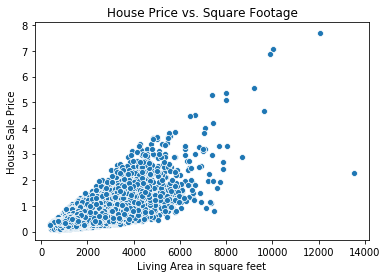

In [66]:
ax = sns.scatterplot(x="sqft_living", y="price_millions", data=df_model)
ax.set_title("House Price vs. Square Footage")
ax.set_xlabel("Living Area in square feet")
ax.set_ylabel("House Sale Price")



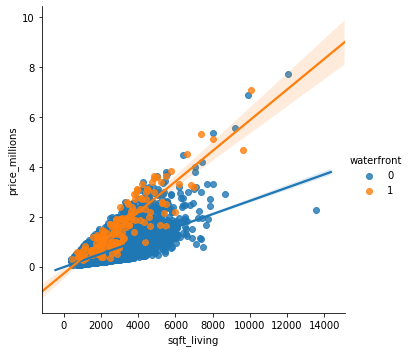

In [65]:
sns.lmplot(x="sqft_living", y="price_millions", data=df_model, hue="waterfront")


### Normalize Numeric Data
#### min-max feature scaling

In [67]:
# copy the data
df_min_max_scaled = df_model.copy()

# apply normalization techniques
for column in df_min_max_scaled.columns:
	df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())	

# view normalized data
print(df_min_max_scaled)

       bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0       0.06250   0.066667     0.061503  0.003108     0.0         0.0   
1       0.06250   0.233333     0.167046  0.004072     0.4         0.0   
2       0.03125   0.066667     0.030372  0.005743     0.0         0.0   
3       0.09375   0.333333     0.120729  0.002714     0.0         0.0   
4       0.06250   0.200000     0.099468  0.004579     0.0         0.0   
...         ...        ...          ...       ...     ...         ...   
21592   0.06250   0.266667     0.088079  0.000370     0.8         0.0   
21593   0.09375   0.266667     0.147304  0.003206     0.4         0.0   
21594   0.03125   0.033333     0.049355  0.000503     0.4         0.0   
21595   0.06250   0.266667     0.093394  0.001132     0.4         0.0   
21596   0.03125   0.033333     0.049355  0.000337     0.4         0.0   

       condition  grade  yr_built  price_millions  
0            0.5    0.4  0.478261        0.018880  
1            0.5   

# MODELING
- Tune models to get the highest performance possible on our task
  - Considerations:
    - What kind of task? Classification task? Regression task?
    - Which models will we use
    - Will be use regularization?
    - How will we validate our model?
    - Loss functions?
    - What is the performance threshold for success?


# EVALUATION
- Does the model solve business problem outlined in step 1?
- At this point, we may want to start over at the business understanding step, now that we have a deeper understanding
- Things we may learn at this stage:
    - Need different data
    - Need more data
    - Should be going in a different direction
    - Should use classificaion rather than regression, or vice versa
    - Use different approach